In [1]:
import sys
sys.path.append('../src')
from scipy.io import loadmat, wavfile
from scipy.interpolate import RegularGridInterpolator
import re, glob
from utils import *
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import stft
from ava.models.vae_dataset import get_syllable_partition
from ava.models.vae_dataset import get_syllable_data_loaders
rng = np.random.default_rng()

## Read data

In [2]:
days = [40]
spec_dirs = ['../audio_spec/%d' % _ for _ in days]

In [3]:
split = 0.5

# Construct a random train/test partition.
partition = get_syllable_partition(spec_dirs, split)

# Make Dataloaders.
loaders = get_syllable_data_loaders(partition, batch_size=128)
len(loaders['train'])

31

In [4]:
for i, spec in enumerate(loaders['train']):
    # spec = spec[:,:,5:-5]
    print(spec.shape)
    break # just to get a slice
sample = spec.numpy()

torch.Size([128, 50, 20])


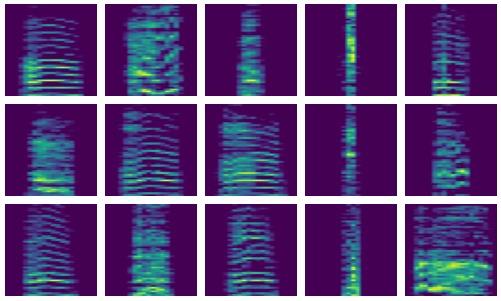

In [5]:
%matplotlib inline
fig, ax = plt.subplots(3, 5, figsize=(5, 3), sharex='all', sharey='all')
ax = ax.flatten()
for i in range(len(ax)):
    j = rng.integers(0, len(sample))
    ax[i].imshow(sample[j], aspect='auto', origin='lower')
    ax[i].set_axis_off()
fig.savefig('../svg/juven_spec.svg')

In [6]:
adult = np.load('../adult_songs/data.npz')
n_samples, n_syl = adult['spec_syl'].shape[:2]
pert_syl_idx = adult['pert_syl_idx']

# adult song used for training
adult_train = torch.tensor(adult['spec_syl'][:n_samples//2], dtype=torch.float32)
adult_train = torch.concatenate([_ for _ in adult_train])

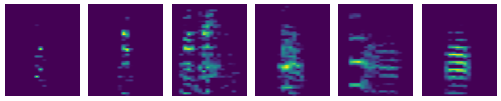

In [7]:
fig, ax = plt.subplots(1, n_syl, sharex='all', sharey='all', figsize=(5, 1))
for i in range(n_syl):
    ax[i].imshow(adult['spec_syl'][1,i], origin='lower', aspect='auto')
    ax[i].set_axis_off()
fig.savefig('../svg/adult_spec.svg')

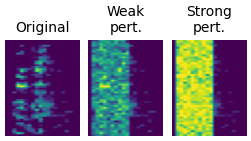

In [8]:
fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(2.5, 1.4))
for i, j in enumerate(('Original', 'Weak\npert.', 'Strong\npert.')):
    if i > 0:
        ax[i].imshow(adult['spec_syl_pert'][i-1][1], origin='lower', aspect='auto')
    else:
        ax[0].imshow(adult['spec_syl'][1,adult['pert_syl_idx']])
    ax[i].set_axis_off()
    ax[i].set_title(j)
fig.savefig('../svg/adult_spec_pert.svg')

### Effective dimension of the data

7.9140496


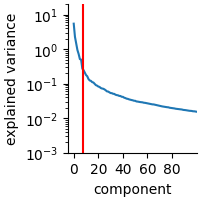

In [9]:
from sklearn.decomposition import PCA
pca = PCA()
_ = np.vstack([sample.reshape(sample.shape[0],-1), 
               adult_train.numpy().reshape(adult_train.shape[0],-1)])
pca.fit(_)
fig, ax = plt.subplots(1, figsize=(2,2))
ax.plot(pca.explained_variance_)
ax.set(xlabel='component', ylabel='explained variance', yscale='log', 
       xlim=[-5, 100], xticks=[0, 20, 40, 60, 80], ylim=[1e-3, 2e1])
dim_syl = ((pca.singular_values_**2).sum()**2)/(pca.singular_values_**4).sum()
ax.axvline(dim_syl, color='r')
print(dim_syl)
fig.savefig('../svg/supplementary/spec_pca_dim.svg')

## Model definition

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

mse = nn.MSELoss(reduction='mean')

def normalize01(x, dims):
    xmin = x.min(dim=dims, keepdims=True).values
    xmax = x.max(dim=dims, keepdims=True).values
    x = (x - xmin) / (xmax - xmin)
    # x = x / x.std(dim=dims, keepdims=True)
    return x

class SparseCoding(nn.Module):
    def __init__(self, n_basis, n_freq_bins, n_time_bins, 
                 sparse_loss='l1', lam_rel=0.2, device=None):
        super(SparseCoding, self).__init__()
        self.n_basis = n_basis
        self.n_freq_bins, self.n_time_bins = n_freq_bins, n_time_bins
        self.device = torch.device('cpu') if device is None else device
        self.basis = torch.randn((n_freq_bins * n_time_bins, n_basis), 
                                 requires_grad=True).to(device)

        self.basis_optimizer = torch.optim.Adam([{'params': self.basis, 'lr': 1e-3}])

        if sparse_loss == 'smooth':
            self.sparse_loss = lambda x: torch.log(1+x**2).mean()
        elif sparse_loss == 'l1':
            self.sparse_loss = lambda x: torch.abs(x).mean()
        self.lam_rel = lam_rel

    def response(self, spec, n_iter):
        # assume spec is normalized
        a = torch.zeros((spec.shape[0], self.n_basis), 
                        requires_grad=True, device=self.device)
        with torch.no_grad():
            a.data += 0.5 / self.n_basis
        # solve BA = X^T for initial condition
        # with torch.no_grad():
        #     a.data = torch.linalg.lstsq(self.basis, spec.T).solution.T
        # scaling constant
        sig = spec.std()
        lam = self.lam_rel * sig
        self.basis.requires_grad = False # need to disable when opt a
        optimizer = torch.optim.Adam([{'params': a, 'lr': 1e-3}])
        old_loss = 1e-10
        for _ in range(n_iter):
            optimizer.zero_grad()
            pred = a @ self.basis.T
            loss = mse(pred, spec) + lam * self.sparse_loss(a/sig)
            loss.backward()
            optimizer.step()
            # with torch.no_grad():
            #     a /= a.std(dim=1, keepdims=True)
            if np.abs(old_loss - loss.item()) / old_loss < 1e-3:
                break
            old_loss = loss.item()
        self.basis.requires_grad = True # set it back
        a = a.detach()
        return a
        
    def single_pass(self, spec, n_iter_coef, n_iter_basis):
        # assume spec originally has shape (batch_size, n_freq_bins, n_time_bins)
        spec = spec.flatten(-2, -1)
        spec = normalize01(spec, dims=-1)
        a = self.response(spec, n_iter_coef) # (batch_size, n_basis)
        for i in range(n_iter_basis):
            self.basis_optimizer.zero_grad()
            pred = a @ self.basis.T
            loss = mse(pred, spec)
            loss.backward()
            self.basis_optimizer.step()
        with torch.no_grad():
            self.basis /= self.basis.std(dim=0, keepdims=True)
        return a, loss.item()
        
    def forward(self, spec, n_iter_coef=50, pad=0, stride=1, train=False, n_iter_basis=60):
        if len(spec.shape) == 3: # (batch_size, n_freq_bins, n_time_bins) 
            batch_size = spec.shape[0]
        elif len(spec.shape) == 2: # (n_freq_bins, n_time_bins)
            batch_size = 1
            spec = spec[None,...]
        T = spec.shape[-1]
        # (n_freq_bins, batch_size, n_time_bins)
        spec_ = torch.zeros((batch_size,self.n_freq_bins,T+pad*2))
        spec_[...,pad:T+pad] = spec

        a, dbasis = [], []
        for t in range(0, T-self.n_time_bins+1, stride):
            if train:
                ret = self.single_pass(spec_[...,t:t+self.n_time_bins], n_iter_coef, n_iter_basis)
                a.append(ret[0])
                dbasis.append(ret[1])
            else:
                x = spec_[...,t:t+self.n_time_bins].flatten(-2, -1)
                x = normalize01(x, dims=-1)
                a.append(self.response(x, n_iter_coef))
        
        a = torch.stack(a, dim=-1) # (batch_size, n_basis, time)
        if train:
            return a, dbasis
        else:
            return a

## Model Training

In [28]:
net = SparseCoding(n_basis=100, n_freq_bins=sample.shape[1], n_time_bins=20)
EPOCH = 25
dBs, sparsity = [], []

In [29]:
for epoch in tqdm(range(EPOCH), disable=False):
    aux_dB, aux_sp = [], []
    for i, spec in tqdm(enumerate(loaders['train']), total=len(loaders['train']), disable=True):
        a, dB = net(spec, train=True)
        a = a.numpy()
        aux_dB.append(dB)
        aux_sp.append((np.abs(a) > a.std()).mean())

    a = net(adult_train, train=True)
    dBs.append(aux_dB)
    sparsity.append(aux_sp)
    # print('[%d] dB = %.3E, sparsity = %.3E' % (epoch, np.mean(aux_dB), np.mean(aux_sp)))

100%|███████████████████████████████████████████| 25/25 [01:10<00:00,  2.81s/it]


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Step')]

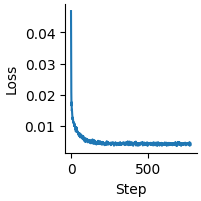

In [30]:
fig, ax = plt.subplots(1, figsize=(2, 2))
ax.plot(np.vstack(dBs))
ax.set(ylabel='Loss', xlabel='Step')

In [31]:
torch.save(net.basis, 'net_params.pkl')

In [32]:
net.basis = torch.load('net_params.pkl')

### Learned filters

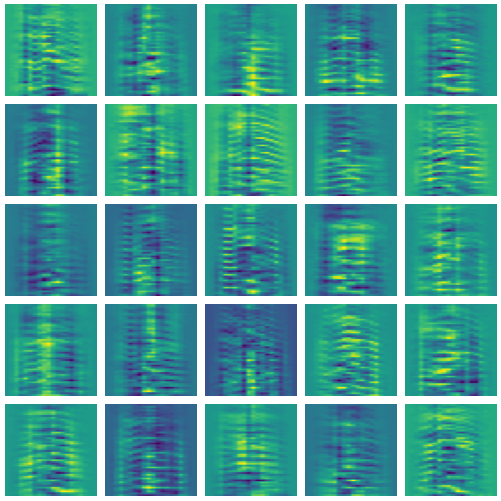

In [33]:
fig, ax = plt.subplots(5, 5, figsize=(5,5))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(net.basis[:,i].detach().reshape(net.n_freq_bins, net.n_time_bins).numpy(), 
                 aspect='auto', interpolation='antialiased', origin='lower')
    ax[i].set_axis_off()
fig.savefig('../svg/supplementary/learned_filters.svg')

### Check reconstructions

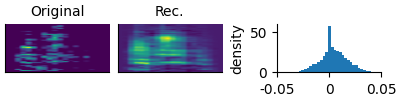

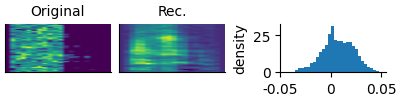

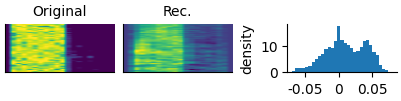

In [34]:
# sanity check
t0 = 0
x0s = [adult['spec_syl'][i,pert_syl_idx], 
       adult['spec_syl_pert'][0][i], adult['spec_syl_pert'][1][i]]
xs = [torch.tensor(adult['spec_syl'][:,pert_syl_idx], dtype=torch.float32).flatten(-2, -1),
      torch.tensor(adult['spec_syl_pert'][0], dtype=torch.float32).flatten(-2, -1),
      torch.tensor(adult['spec_syl_pert'][1], dtype=torch.float32).flatten(-2, -1)]
for j, x in enumerate(xs):
    x = normalize01(x, dims=-1)
    a = net.response(x, n_iter=500)
    a = a.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(4, 1))
    i = -1
    rec = net.basis.detach().numpy() @ a[i]
    ax[0].imshow(x0s[j], origin='lower')
    ax[1].imshow(rec.reshape(net.n_freq_bins, net.n_time_bins), origin='lower')
    ax[2].hist(a.flatten(), bins=31, density=True)
    ax[0].set(xticks=[], yticks=[], title='Original')
    ax[1].set(xticks=[], yticks=[], title='Rec.')
    ax[2].set(xticks=[-0.05, 0, 0.05], xticklabels=[-0.05, '0', 0.05], ylabel='density')
    fig.savefig('../svg/supplementary/rec%d.svg' % j)

## Generate data for training vocal error models

In [35]:
y_ctrl = np.stack([net(torch.tensor(adult['spec_syl'][n_samples//2:,i]), n_iter_coef=200).numpy() 
                   for i in range(n_syl)], axis=2)[...,0]
_ = adult['spec_syl'][n_samples//2:].copy()
_[:,pert_syl_idx] = adult['spec_syl_pert'][0][n_samples//2:]
y_pert_weak = np.stack([net(torch.tensor(_[:,i]), n_iter_coef=200).numpy() 
                       for i in range(n_syl)], axis=2)[...,0]
_[:,pert_syl_idx] = adult['spec_syl_pert'][1][n_samples//2:]
y_pert_strong = np.stack([net(torch.tensor(_[:,i]), n_iter_coef=200).numpy() 
                         for i in range(n_syl)], axis=2)[...,0]
y_ctrl = normalize(y_ctrl, axis=1)
y_pert_weak = normalize(y_pert_weak, axis=1)
y_pert_strong = normalize(y_pert_strong, axis=1)
y_ctrl.shape, y_pert_weak.shape

((65, 100, 6), (65, 100, 6))

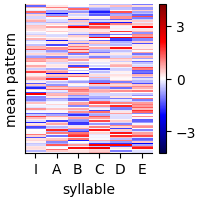

In [36]:
fig, ax = plt.subplots(1, figsize=(2,2))
v = np.abs(y_ctrl).max()
im = ax.imshow(y_ctrl.mean(axis=0), cmap='seismic', interpolation='none', vmin=-v, vmax=v)
ax.set(xlabel='syllable', ylabel='mean pattern', yticks=[],
       xticks=list(range(6)), xticklabels='IABCDE')
fig.colorbar(im, ax=ax, ticks=[-(v//2+1), 0, v//2+1])
fig.savefig('../svg/supplementary/mean_sc_rep.svg')

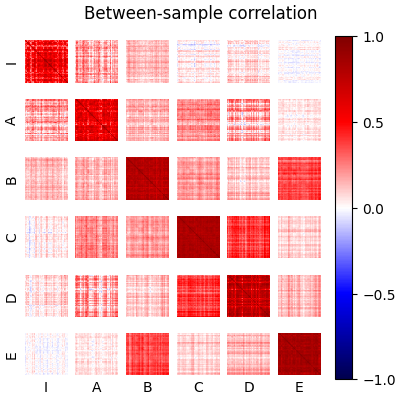

In [80]:
fig, ax = plt.subplots(y_ctrl.shape[-1], y_ctrl.shape[-1], figsize=(4,4))
for i in range(y_ctrl.shape[-1]):
    for j in range(y_ctrl.shape[-1]):
        im = ax[i,j].imshow(correlation(y_ctrl[...,i], y_ctrl[...,j]), 
                            vmin=-1, vmax=1, aspect=1, cmap='seismic')
        ax[i,j].set(xticks=[], yticks=[])
        ax[i,j].spines['left'].set(visible=False)
        ax[i,j].spines['bottom'].set(visible=False)
        ax[-1,j].set_xlabel('IABCDE'[j])
    ax[i,0].set_ylabel('IABCDE'[i])
fig.colorbar(im, ax=ax, ticks=[-1, -0.5, 0, 0.5, 1])
fig.suptitle('Between-sample correlation')
fig.savefig('../svg/supplementary/between_sample_corr.svg')

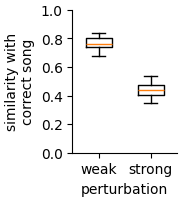

In [79]:
fig, ax = plt.subplots(1, figsize=(1.8, 2))
corr = [correlation(y_ctrl[...,pert_syl_idx], l[...,pert_syl_idx], dim=1, cosine=True) 
        for l in (y_pert_weak, y_pert_strong)]
ax.boxplot(corr, widths=[0.5, 0.5])
ax.set(xticks=[1,2],xticklabels=['weak', 'strong'], xlabel='perturbation', 
       ylabel='similarity with\ncorrect song', ylim=[0, 1])
fig.savefig('../svg/supplementary/similarity_song_perturb.svg')

In [40]:
song_T_max = 800 # ms
target_ts = np.arange(song_T_max) 
song_responses = dict(ctrl=np.zeros((*y_ctrl.shape[:2], len(target_ts))), 
                      pert_weak=np.zeros((*y_pert_weak.shape[:2], len(target_ts))),
                      pert_strong=np.zeros((*y_pert_weak.shape[:2], len(target_ts))))
# Make a filter to generate continuous responses
filt = np.exp(-np.linspace(0, 3, num=80)) #np.ones(50)
filt[:40] = 0
filt /= filt.sum()
# Get responses
for i in tqdm(range(y_ctrl.shape[0])): # batch
    ts = np.linspace(0, adult['song_Ts'][i], num=500)
    aux = np.zeros_like(ts)
    for j in range(y_ctrl.shape[1]):
        aux[:] = 0
        for k in range(n_syl):
            aux[(ts>=adult['syl_on'][i,k])&(ts<adult['syl_off'][i,k])] = y_ctrl[i,j,k]
        song_responses['ctrl'][i,j] = np.interp(target_ts, ts, aux, left=0, right=0)
        song_responses['ctrl'][i,j] = np.convolve(filt, song_responses['ctrl'][i,j], 'same')
        for k in range(n_syl):
            aux[(ts>=adult['syl_on'][i,k])&(ts<adult['syl_off'][i,k])] = y_pert_weak[i,j,k]
        song_responses['pert_weak'][i,j] = np.interp(target_ts, ts, aux, left=0, right=0)
        song_responses['pert_weak'][i,j] = np.convolve(filt, song_responses['pert_weak'][i,j], 'same')
        for k in range(n_syl):
            aux[(ts>=adult['syl_on'][i,k])&(ts<adult['syl_off'][i,k])] = y_pert_strong[i,j,k]
        song_responses['pert_strong'][i,j] = np.interp(target_ts, ts, aux, left=0, right=0)
        song_responses['pert_strong'][i,j] = np.convolve(filt, song_responses['pert_strong'][i,j], 'same')

100%|███████████████████████████████████████████| 65/65 [00:24<00:00,  2.62it/s]


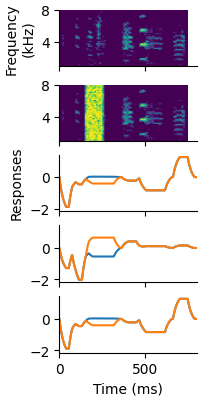

In [41]:
fig, ax = plt.subplots(5, 1, sharex='all', figsize=(2, 4))
i = 0
ax[0].imshow(adult['spec_song'][i], cmap='viridis', 
             extent=(0, adult['song_Ts'][i], 1, 8), origin='lower', aspect='auto')
ax[1].imshow(adult['spec_song_pert'][1][i], cmap='viridis', 
             extent=(0, adult['song_Ts'][i], 1, 8), origin='lower', aspect='auto')
# ax[0].vlines(adult['syl_on'][i], 1, 8, color='r')
# ax[0].vlines(adult['syl_off'][i], 1, 8, color='r', ls=':')
# ax[0].set_xlim([-50, 900])
for l in range(3):
    j = rng.integers(0,net.n_basis)
    ax[2+l].plot(song_responses['ctrl'][i,j].T)
    ax[2+l].plot(song_responses['pert_strong'][i,j].T)
ax[-1].set(xlabel='Time (ms)', xlim=[0, song_T_max])
ax[0].set(ylabel='Frequency\n(kHz)', yticks=[4, 8])
ax[1].set(yticks=[4, 8])
ylim = (min([ax[i].get_ylim()[0] for i in [2,3,4]]), 
        max([ax[i].get_ylim()[1] for i in [2,3,4]]))
ax[2].set(ylabel='Responses', ylim=ylim)
ax[3].set(ylim=ylim)
ax[4].set(ylim=ylim)
fig.savefig('../svg/supplementary/example_sc_out.svg')

In [42]:
song_responses['pert_t0'] = adult['syl_on'][n_samples//2:,pert_syl_idx]
song_responses['pert_t1'] = np.minimum(adult['syl_on'][n_samples//2:,pert_syl_idx]+50, \
                                       adult['syl_off'][n_samples//2:,pert_syl_idx])
np.savez('learned_song_responses.npz', **song_responses)